# **Setup Inicial 0**

In [3]:
!pip install scipy==1.2
!pip3 install pybalu==0.2.5
import pandas as pd
from sklearn.datasets import load_wine, load_boston
from pybalu.feature_selection import sfs, clean
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, plot_confusion_matrix, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
from sklearn.svm import SVR
clear_output()

In [6]:
def minmax(X):
    ma = X.max(0)
    mi = X.min(0)
    md    = ma-mi    
    a     = 1/ md
    b     = -mi/md
    return X * a + b, a, b

# **Parte 1: Problema de regresión**

El dataset que utilizaremos en este ejemplo se llama Boston house-price, cuyo objetivo es tratar de predecir el precio de una casa a partir de distintas características. Puede encontrar el detalle en https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-house-prices-dataset


### **1.0. Cargamos los datos**

In [5]:
boston_data = load_boston()
df_boston = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
df_boston['target'] = pd.Series(boston_data.target)
df_boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [7]:
# Tomamos la matriz de características y los valores a predecir
X = df_boston.values[:,:-1]
y = df_boston.values[:,-1]

In [66]:
y.min(), y.max()

(5.0, 50.0)

Una práctica común es limpiar y preprocesar los datos, en este caso normalizaremos las columnas

In [11]:
X, _, _ = minmax(X)
X

0.0

## **1.1 Hacemos el split de los datos**

In [17]:
np.random.seed(1)

In [12]:
# En este caso tomaremos un split de 80:10:10 train/validation/test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [13]:
len(X_train)/len(X) * 100, len(X_val)/len(X) * 100, len(X_test)/len(X) * 100

(79.84189723320159, 10.079051383399209, 10.079051383399209)

## **1.2 Entrenamos un modelo y hacemos predicciones**

In [65]:
# definimos un modelo
model = LinearRegression()

# Lo fitteamos al conjunto de entrenamiento
model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = model.predict(X_train)

# Calculamos alguna métrica de error
mean_squared_error(y_train, y_pred)


21.641412753226312

In [67]:
# Hacemos predicciones sobre el train para estudiar que tan bien se ajusta a los datos de entrenamiento
y_pred = model.predict(X_train)

# Calculamos alguna métrica de error
mean_squared_error(y_train, y_pred)

21.641412753226312

In [68]:
# Evaluamos en conjunto de testeo
y_pred = model.predict(X_test)

# Calculamos alguna métrica de error
mean_squared_error(y_test, y_pred)

21.402844327746852

## **1.3 Utilizamos el conjunto de validación para mejorar el rendimiento**

In [71]:
# Usamos un modelo que sí tenga parámetros
model = RandomForestRegressor(random_state=1)
# Lo fitteamos al conjunto de entrenamiento
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [74]:
# Hacemos predicciones sobre el train para estudiar que tan bien se ajusta a los datos de entrenamiento
y_pred = model.predict(X_train)

# Calculamos alguna métrica de error
mean_squared_error(y_train, y_pred)

1.838944863861387

Observamos que la regresión lineal tiene un MSE de 21.6 mientras que Random Forest alcanza 1.83 en el set de entrenamiento, lo que nos dice que el último modelo se ajusta mucho mejor a los datos.

In [73]:
# Hacemos predicciones
y_pred = model.predict(X_test)

# Calculamos alguna métrica de error
mean_squared_error(y_test, y_pred)

5.520489568627441

Optimicemos por ejemplo, la cantidad de arboles de desición que utiliza nuestro regresor Random Forest

In [40]:
estimators_list = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
errors_list = []
for n in estimators_list:
    model = RandomForestRegressor(n_estimators=n, random_state=1)
    # Lo fitteamos al conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Hacemos predicciones
    y_pred = model.predict(X_val)

    # Calculamos alguna métrica de error
    error = mean_squared_error(y_val, y_pred)
    print(error)
    errors_list.append(error)

14.578885784313721
12.698849387254898
11.617793082788666
11.223269669117643
11.514377019607844
11.372174700435735
11.897251320528223
11.987433049938746
12.047867816509326
11.626719245098043


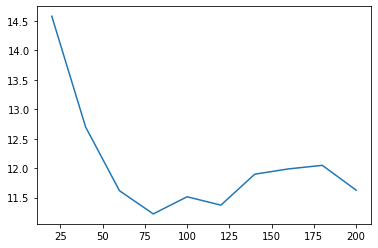

In [41]:
# Podemos plotear la evolución 
plt.plot(estimators_list, errors_list)

In [53]:
estimators_list = [20, 40, 60, 80, 100]
depths_list     = [6, 8, 10, 12, 14, 16]

best_n = None
best_depth = None

params_list = list(product(estimators_list, depths_list))
triumphs = np.array([0] * len(params_list))


best_error = 100
for i in range(len(params_list)):
    n, depth = params_list[i]
    model = RandomForestRegressor(n_estimators=n, max_depth=depth, random_state=1)
    # Lo fitteamos al conjunto de entrenamiento
    model.fit(X_train, y_train)

    # Hacemos predicciones  
    y_pred = model.predict(X_val)

    # Calculamos alguna métrica de error
    error = mean_squared_error(y_val, y_pred)
    if error < best_error:
      best_error = error
      best_n = n
      best_depth = depth

In [54]:
#best_n, best_depth = params_list[np.argmax(triumphs)]
print(best_n, best_depth)

80 12


Evaluamos con la mejor combinación

In [56]:

model = RandomForestRegressor(n_estimators=best_n, max_depth=best_depth, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
error = mean_squared_error(y_test, y_pred)
print(error)

5.417136524653293


# **Parte 2: Problema de clasificación**

## **2.0 Cargamos los datos**

In [4]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [7]:
# Normalizamos la matriz de características
y = data.target
X = df.values
X, _, _ = minmax(X)

In [8]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

## **2.1. Hacemos el split de los datos**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

## **2.2. Optimización de hiperparámetros**

In [85]:
model = LogisticRegression(C=2)
# Lo fitteamos al conjunto de entrenamiento
model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = model.predict(X_test)

# Calculamos alguna métrica de error
accuracy_score(y_test, y_pred)

1.0

In [87]:
y_pred, y_test

(array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0]),
 array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0]))

In [88]:
# Usamos un modelo que sí tenga parámetros
model = AdaBoostClassifier()
# Lo fitteamos al conjunto de entrenamiento
model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = model.predict(X_test)

# Calculamos alguna métrica de error
accuracy_score(y_test, y_pred)

0.9444444444444444

In [89]:
y_pred, y_test

(array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0]),
 array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0]))

In [90]:
# Se optimizará el número de weak clasifiers y learning rates

# Se generará una malla para generar 100 modelos AdaBoost
estimators_list = map(int, np.linspace(50, 200, 10))
lr_list         = np.linspace(0.001, 1.5, 10)

max_acc = 0
best_estimators = 0
best_lr = 0

for n, lr in product(estimators_list, lr_list):
  clf = AdaBoostClassifier(n_estimators=n, learning_rate=lr)
  clf.fit(X_train, y_train)
  # Hacemos predicciones
  y_pred = clf.predict(X_val)
  acc = accuracy_score(y_val, y_pred)
  if acc > max_acc:
    max_acc = acc
    best_estimators  = n
    best_lr          = lr
    print(f'NEW MAX: Accuracy con n_estimators={n} y learning rate={lr}: {acc * 100}% en set de validación')

NEW MAX: Accuracy con n_estimators=50 y learning rate=0.001: 83.33333333333334% en set de validación
NEW MAX: Accuracy con n_estimators=50 y learning rate=0.16755555555555557: 94.44444444444444% en set de validación
NEW MAX: Accuracy con n_estimators=50 y learning rate=1.5: 100.0% en set de validación


In [91]:
model = AdaBoostClassifier(n_estimators=best_estimators, learning_rate=best_lr)
# Lo fitteamos al conjunto de entrenamiento
model.fit(X_train, y_train)

# Hacemos predicciones
y_pred = model.predict(X_test)

# Calculamos alguna métrica de error
accuracy_score(y_test, y_pred)

1.0

In [95]:
y_pred, y_test

(array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0]),
 array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0]))

También podemos reportar la matriz de confusión

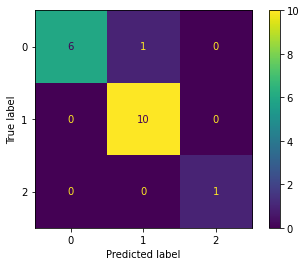

In [98]:
# Usamos un modelo que sí tenga parámetros
model = AdaBoostClassifier()
# Lo fitteamos al conjunto de entrenamiento
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Calculamos alguna métrica de error
plot_confusion_matrix(model, X_test, y_test)

In [99]:
y_pred, y_test

(array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0]),
 array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 1, 1, 0]))

## **2.3. Visualización con PCA**

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [11]:
X_pca.shape

(178, 2)

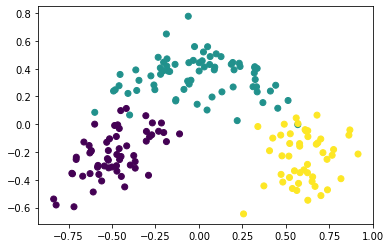

In [12]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

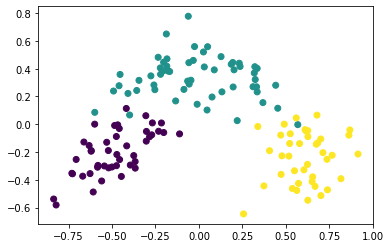

In [14]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

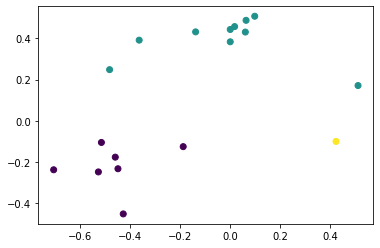

In [15]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

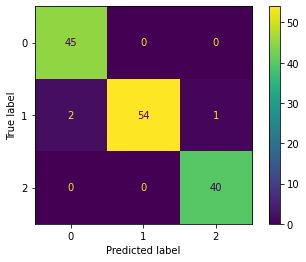

In [115]:
# Usamos un modelo que sí tenga parámetros
model = SVC()
# Lo fitteamos al conjunto de entrenamiento
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Calculamos alguna métrica de error
plot_confusion_matrix(model, X_train, y_train)

No handles with labels found to put in legend.


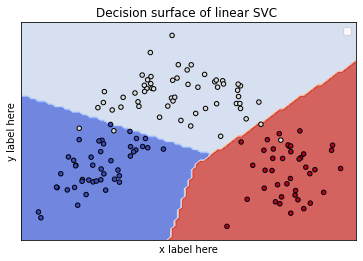

In [126]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 0.1, x.max() + 0.1
    y_min, y_max = y.min() - 0.1, y.max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

model = SVC(kernel='linear')
model.fit(X_train, y_train)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of linear SVC ')
# Set-up grid for plotting.
X0, X1 = X_train[:, 0], X_train[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('y label here')
ax.set_xlabel('x label here')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

In [121]:
X_train.shape

(142, 2)

## **2.4. Guardar el modelo entrenado y cargarlo después para hacer predicciones**

In [127]:
import joblib

# Guardamos el modelo
joblib.dump(model, 'svm')

['svm']

In [27]:
import joblib


# Lo cargamos para usarlo
model2 = joblib.load('svm')

# Tenemos que usar reshape para pasarle solo una muestra
y_pred = model2.predict(X_test[0].reshape(1, -1))

y_pred

array([0])